<a href="https://colab.research.google.com/github/alexeybogusevich/Penguins/blob/main/Lab1_SupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Пінгвіни

Розмір датасету: 344 x 7

Фічі: 
"стать", 
"острів, на якому проживають", 
"довжина дзьоба", 
"глибина дзьоба", 
"довжина крила", 
"маса тіла"

Таргет:
"вид"

In [ ]:
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Перевіримо датасет на повноту. 


In [ ]:
def get_missing_count(data):
  missing_count = data.isnull().sum()
  missing_count = missing_count[missing_count > 0]
  return missing_count

In [ ]:
missing_count = get_missing_count(penguins)
print(missing_count)

bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64



*   Для числових фіч замість NULL підставимо медіану.

In [ ]:
clean_penguins = penguins.copy()
clean_penguins['bill_length_mm'] = penguins['bill_length_mm'].transform(lambda x: x.fillna(x.median()))
clean_penguins['bill_depth_mm'] = penguins['bill_depth_mm'].transform(lambda x: x.fillna(x.median()))
clean_penguins['flipper_length_mm'] = penguins['flipper_length_mm'].transform(lambda x: x.fillna(x.median()))
clean_penguins['body_mass_g'] = penguins['body_mass_g'].transform(lambda x: x.fillna(x.median()))

In [ ]:
missing_count = get_missing_count(clean_penguins)
print(missing_count)

sex    11
dtype: int64


Візуалізуємо розподіл числових даних.
За графіками можна зробити наприклад такі висновки:


1.   Вид Adelie виокремлюється за рахунок довжини дзьоба
2.   Вид Gentoo виокремлюється за рахунок глибини дзьоба та довжини крила




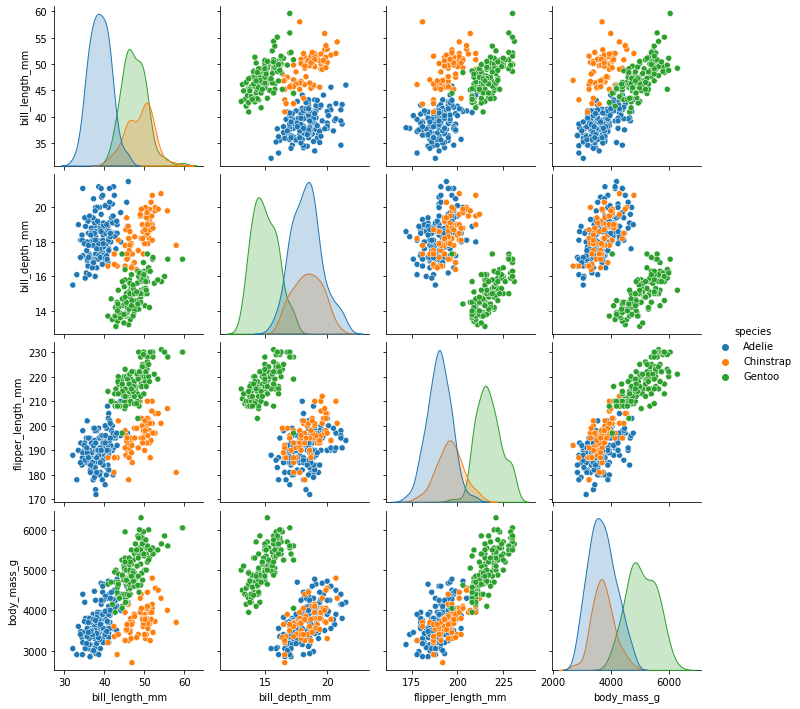

In [ ]:
sns.pairplot(clean_penguins, hue='species')


In [ ]:
numeric_data = clean_penguins.select_dtypes(include = [np.number])
categorical_data = clean_penguins.select_dtypes(exclude = [np.number])

Наведемо кореляційну матрицю. Бачимо, що найбільш пов'язаними між собою фічами є довжина крила та маса тіла. Це є не дуже гарною ознакою для Наївного Баєса, оскільки той припускає, що усі змінні незалежні між собою.

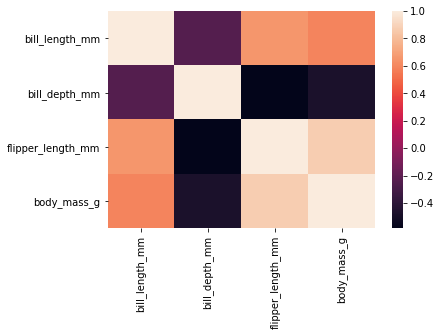

In [ ]:
corr = numeric_data.corr()
sns.heatmap(corr)

В цьому датасеті стать не впливає на результат, адже в кожному виді самців та самок майже порівну.

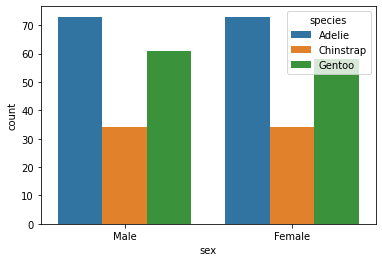

In [ ]:
ax = sns.countplot(x="sex", hue='species', data=clean_penguins)

А ось острів, на якому живе пінгвін, є цінною інформацію при визначенні виду 

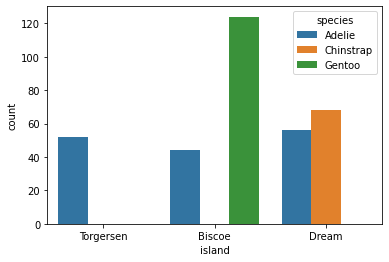

In [ ]:
ax = sns.countplot(x="island", hue='species', data=clean_penguins)

Перетворимо важливу категоріальну змінну на набір булевих.

In [ ]:
bool_islands = clean_penguins.island.str.get_dummies()
bool_islands.columns = [col + '_island' for col in bool_islands.columns]
print(bool_islands)

     Biscoe_island  Dream_island  Torgersen_island
0                0             0                 1
1                0             0                 1
2                0             0                 1
3                0             0                 1
4                0             0                 1
..             ...           ...               ...
339              1             0                 0
340              1             0                 0
341              1             0                 0
342              1             0                 0
343              1             0                 0

[344 rows x 3 columns]


In [ ]:
clean_penguins = pd.concat([clean_penguins, bool_islands], axis=1)
clean_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,Biscoe_island,Dream_island,Torgersen_island
0,Adelie,Torgersen,39.10,18.7,181.0,3750.0,Male,0,0,1
1,Adelie,Torgersen,39.50,17.4,186.0,3800.0,Female,0,0,1
2,Adelie,Torgersen,40.30,18.0,195.0,3250.0,Female,0,0,1
3,Adelie,Torgersen,44.45,17.3,197.0,4050.0,NaN,0,0,1
4,Adelie,Torgersen,36.70,19.3,193.0,3450.0,Female,0,0,1
...,...,...,...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,44.45,17.3,197.0,4050.0,NaN,1,0,0
340,Gentoo,Biscoe,46.80,14.3,215.0,4850.0,Female,1,0,0
341,Gentoo,Biscoe,50.40,15.7,222.0,5750.0,Male,1,0,0
342,Gentoo,Biscoe,45.20,14.8,212.0,5200.0,Female,1,0,0


Для навчання відкидаємо таргет, категорійну змінну, що не впливає на результат, та вже трансформовану категорійну змінну.

In [ ]:
X_penguins = clean_penguins.drop('sex', axis=1).drop('island', axis=1).drop('species', axis=1)\
                              .drop('Biscoe_island', axis=1).drop('Dream_island', axis=1).drop('Torgersen_island', axis=1)
X_penguins.shape

(344, 4)

In [ ]:
y_penguins = clean_penguins['species']
y_penguins.shape

(344,)

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_penguins, y_penguins, random_state=1)

Спочатку out-of-box класифікатор.

In [ ]:
model = GaussianNB()
model.fit(Xtrain, ytrain);

In [ ]:
y_model = model.predict(Xtest)  

In [ ]:
accuracy_score(ytest, y_model)        

0.9651162790697675

In [ ]:
oob_confusion_matrix = confusion_matrix(ytest, y_model)
oob_confusion_matrix

array([[40,  2,  0],
       [ 1, 13,  0],
       [ 0,  0, 30]])

In [ ]:
def get_TPR_FPR_ACC(confusion_matrix_model):

  FP = confusion_matrix_model.sum(axis=0) - np.diag(confusion_matrix_model)  
  FN = confusion_matrix_model.sum(axis=1) - np.diag(confusion_matrix_model)
  TP = np.diag(confusion_matrix_model)
  TN = confusion_matrix_model.sum() - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)

  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)

  return TPR, FPR, ACC

In [ ]:
oob_tpr, oob_fpr, oob_acc = get_TPR_FPR_ACC(confusion_matrix_bout_of_box)

In [ ]:
print('True Positive Rate: ', oob_tpr)
print('False Positive Rate: ', oob_fpr)
print('Accuracy: ', oob_acc)

True Positive Rate:  [0.95238095 0.92857143 1.        ]
False Positive Rate:  [0.02272727 0.02777778 0.        ]
Accuracy:  [0.96511628 0.96511628 1.        ]


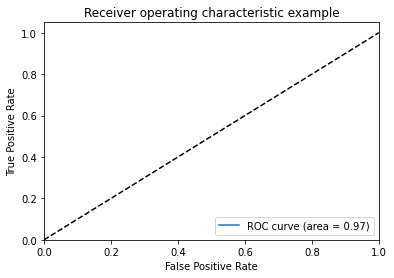

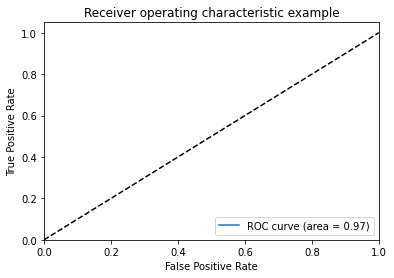

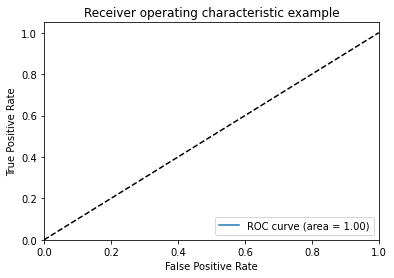

In [ ]:
%matplotlib inline
for i in range(len(list(set(ytest)))):
    plt.figure()
    plt.plot(oob_fpr[i], oob_tpr[i], label='ROC curve (area = %0.2f)' % oob_acc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Тепер in-house класифікатор.

In [ ]:
def separate_classes(X, y):
    separated_classes = {}
    for i in X.index:
      feature_values = X.loc[i, :].values
      class_name = y.loc[i]
      if class_name not in separated_classes:
          separated_classes[class_name] = []
      separated_classes[class_name].append(feature_values)
    return separated_classes

In [ ]:
def summarize(X):
    for feature in zip(*X):
        yield {
            'stdev' : np.std(feature),
            'mean' : np.mean(feature)
        }

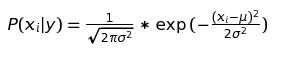

In [ ]:
def gauss_distribution_function(x, mean, stdev):
    exponent = np.exp(-((x-mean)**2 / (2*stdev**2)))
    return exponent / (np.sqrt(2*np.pi)*stdev)

In [ ]:
def fit(X, y):
    separated_classes = separate_classes(X, y)
    class_summary = {}
    for class_name, feature_values in separated_classes.items():
        class_summary[class_name] = {
            'prior_proba': len(feature_values)/len(X),
            'summary': [i for i in summarize(feature_values)],
        }     
    return class_summary

In [ ]:
class_summary = fit(Xtrain, ytrain)
class_summary

{'Adelie': {'prior_proba': 0.4263565891472868,
  'summary': [{'mean': 38.71045454545455, 'stdev': 2.6587599250107137},
   {'mean': 18.30818181818182, 'stdev': 1.234513656037125},
   {'mean': 189.74545454545455, 'stdev': 6.219377875400786},
   {'mean': 3695.909090909091, 'stdev': 465.8268220048879}]},
 'Chinstrap': {'prior_proba': 0.20930232558139536,
  'summary': [{'mean': 48.522222222222226, 'stdev': 3.1303571365691067},
   {'mean': 18.39074074074074, 'stdev': 1.124354715104281},
   {'mean': 195.62962962962962, 'stdev': 6.934338325390097},
   {'mean': 3702.777777777778, 'stdev': 346.1316205801373}]},
 'Gentoo': {'prior_proba': 0.3643410852713178,
  'summary': [{'mean': 47.296276595744686, 'stdev': 3.0233685539239996},
   {'mean': 14.928723404255324, 'stdev': 1.0329283244711582},
   {'mean': 216.31914893617022, 'stdev': 6.381843870746446},
   {'mean': 5037.5, 'stdev': 515.0365355765776}]}}

Застосовуємо формулу Байеса до кожної з фіч, після чого результуючі значення перемножуємо та порівнюємо для різних класів
https://doinalangille.com/2020-06-26-naive-bayes-classifier-from-scratch/


In [ ]:
def predict(X):
    MAPs = []
    for row in X:
        joint_proba = {}
        for class_name, features in class_summary.items():
            total_features = len(features['summary'])
            likelihood = 1
            for idx in range(total_features):
                feature = row[idx]
                mean = features['summary'][idx]['mean']
                stdev = features['summary'][idx]['stdev']
                normal_proba = gauss_distribution_function(feature, mean, stdev)
                likelihood *= normal_proba
            prior_proba = features['prior_proba']
            joint_proba[class_name] = prior_proba * likelihood
        MAP = max(joint_proba, key=joint_proba.get)
        MAPs.append(MAP)
    return MAPs

In [ ]:
def accuracy(y_test, y_pred):
    true_true = 0
    for y_t, y_p in zip(y_test, y_pred):
        if y_t == y_p:
            true_true += 1
    return true_true / len(y_test)

In [ ]:
fit(Xtrain, ytrain)
ypred = predict(Xtest.values)
print ("GaussianNBClassifier accuracy: {0:.3f}".format(accuracy(ytest, ypred)))

GaussianNBClassifier accuracy: 0.965


ROC-крива та відповідна площа під нею (AUC) рахуються на основі матриці невідповідностей:
https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

In [ ]:
ih_confusion_matrix = confusion_matrix(ytest, ypred)
ih_confusion_matrix

array([[40,  2,  0],
       [ 1, 13,  0],
       [ 0,  0, 30]])

In [ ]:
print('True Positive Rate: ', oob_tpr)
print('False Positive Rate: ', oob_fpr)
print('Accuracy: ', oob_acc)

True Positive Rate:  [0.95238095 0.92857143 1.        ]
False Positive Rate:  [0.02272727 0.02777778 0.        ]
Accuracy:  [0.96511628 0.96511628 1.        ]
